In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
import scipy.signal as sig
from scipy.signal import find_peaks
from scipy.ndimage import shift
import itertools
import pickle
from pathlib import Path

from lmfit.models import GaussianModel, LinearModel

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak_LE.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()

print(exampleObj)

                                                                    Z1  \
                                                                    QI   
72209162200 20309    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            40339    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            50269    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60108    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60849    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
...                                                                ...   
72209172155 2020326  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2020591  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2030429  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060050  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060679  [65532, 65532, 65532, 65532, 65532, 65532, 655...   

                                     

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#import singularity_pulseSave as sps
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-lt-50keV.txt')

#pulse_struct = sps.parseEventList('../coin_analysis/data/r76_events_coincidencepeak.txt')

   SeriesNumber  EventNumber
0   72209162200        20309
1   72209162200        40339
2   72209162200        50269
3   72209162200        60108
4   72209162200        60849
5   72209162200        80307
6   72209162200       100246
7   72209162200       110588
8   72209162200       110617
9   72209162200       120647
[72209162200 72209171225 72209172155]
[  20309   40339   50269   60108   60849   80307  100246  110588  110617
  120647  120688  130460  140628  150823  160296  170423  180002  180423
  230432  240270  270221  340151  340912  380054  380186  390511  420391
  420816  430710  440168  480387  480389  500725  520930  540170  540903
  550322  560707  560931  570415  580008  580723  590121  610172  610663
  610684  640653  650751  670228  670650  690338  710437  740337  750334
  750490  760179  770287  780145  780259  780278  780628  800530  810923
  820568  840012  840222  850265  860663  880573  880913  910282  920809
  920948  930239  930872  940631  950888  960920  970767 10

In [5]:
coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])

def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

# ax1.fill_between(np.arange(0, best_cross + 1), bshifted_pT[:best_cross + 1], 0, color='gray', alpha=0.5)
                
              #      area = np.trapz(bshifted_pT[:best_cross + 1], dx=1)
                #    print("Area:", area)
def getPTPulse(pulses,series=72209162200,ev=20309,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        #print(mean)
        pulse = pulse-mean
        #print(pulse)
        #print(np.size(ptpulse))
        if(ccount==0):
            ptpulse=pulse
        else:
            ptpulse+=pulse
        ccount+=1
        
    return ptpulse


def getPTPulseCD(pulses,series=72209162200,ev=20309):
    
    pulse = getPTPulse(pulses, series, ev)

    #adding discriminator
    D = 100

    end_values = pulse[3997:]
    
    CD_pulse = shift(pulse, D, cval=np.nan)

    #adding the cut off values to the front of the new pulse
    CD_pulse[0:99] = end_values
    #print(new_pulse)
        
    return CD_pulse

def getBadBL(pulses, series=72209162200, ev=20309):
    pulse = getPTPulseCD(pulses, series, ev)
    asdf = np.linspace(150, 300)
    asdfg = pulse[np.round(asdf).astype(int)]  # Round and convert to int
    asdf1 = np.linspace(2500, 3000)
    asdfg1 = pulse[np.round(asdf1).astype(int)]  # Round and convert to int
    lowBinAvg = np.mean(asdfg)
    hiBinAvg = np.mean(asdfg1)
    if np.abs(hiBinAvg - lowBinAvg) > 400:
        return True
    else:
        return False
        

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)


In [6]:
loops = 0
time_reg = []
energies = []
bad=[]
goodevs=[]
plot=False

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                if best_cross<500:
                    bad.append(loops)
                elif (energy<15):
                    goodevs.append(ev)
                    
            if (plot==True) and (getBadBL(exampleObj,ser,ev)) and (energy<15):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1

Series Number: 72209162200
Event Number: 50269
Energy: 40.07287564851 keV


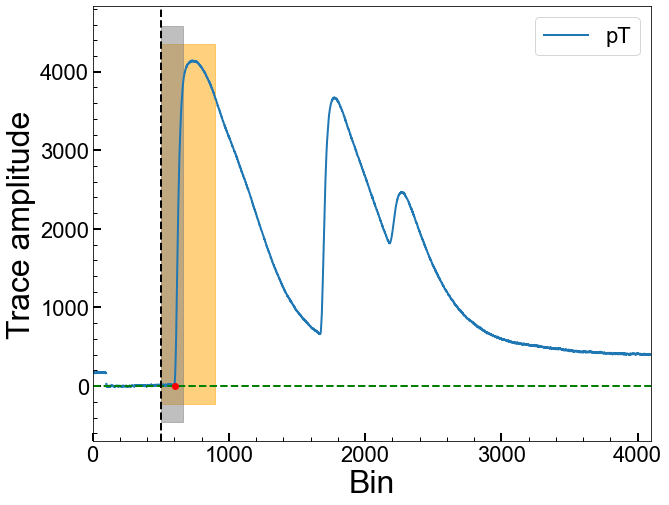

Series Number: 72209162200
Event Number: 560931
Energy: 37.38332924631 keV


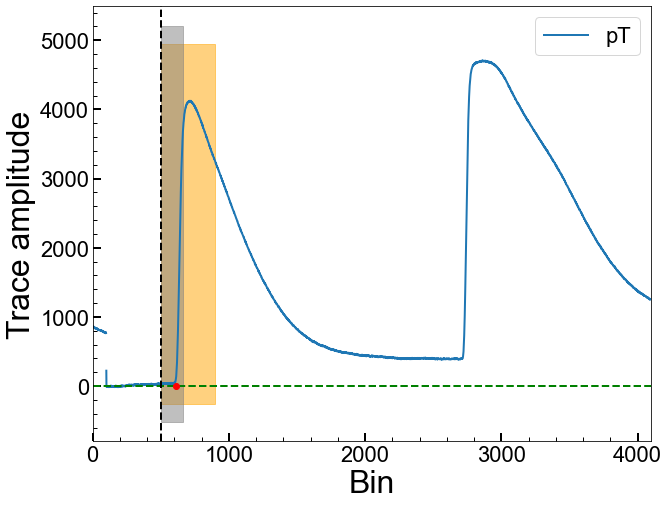

Series Number: 72209162200
Event Number: 580008
Energy: 33.97321412501 keV


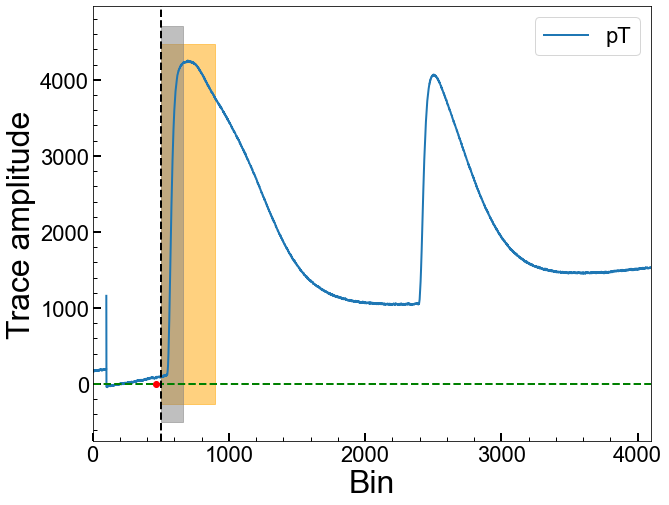

Series Number: 72209162200
Event Number: 780628
Energy: 39.48083097848 keV


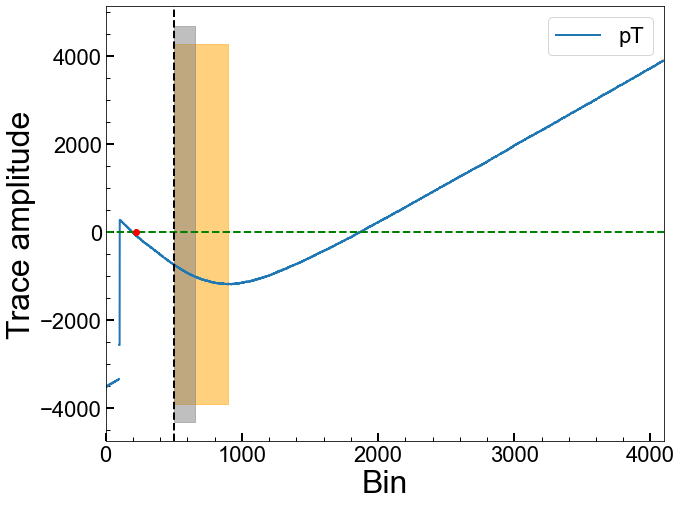

Series Number: 72209162200
Event Number: 910282
Energy: 49.57420649544 keV


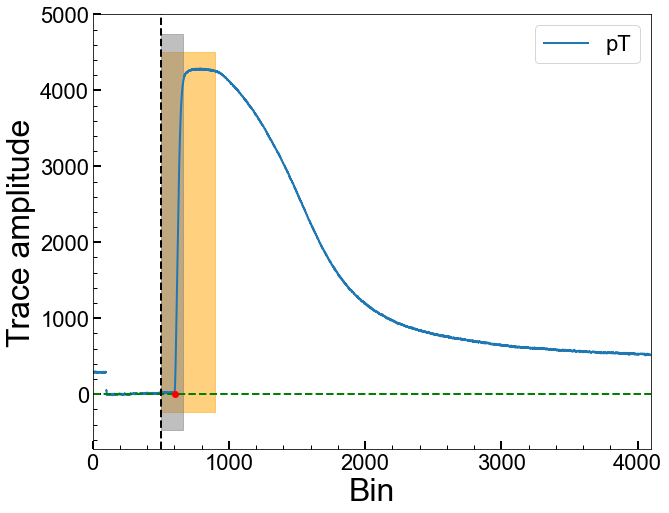

Series Number: 72209162200
Event Number: 1070509
Energy: 47.55945117602 keV


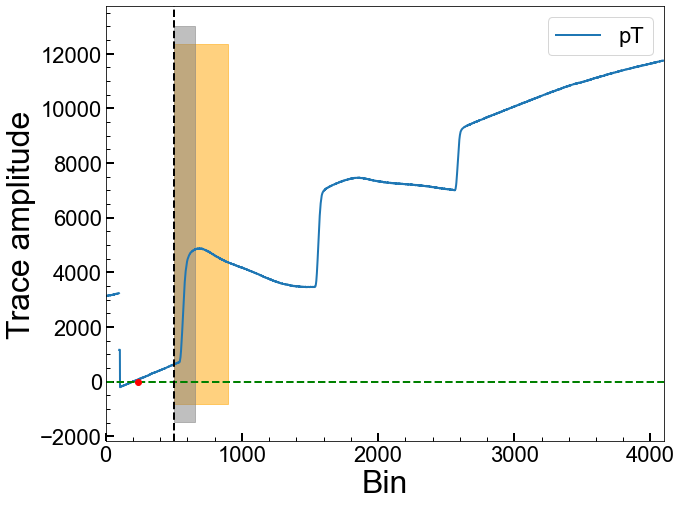

Series Number: 72209162200
Event Number: 1110143
Energy: 36.21041003857 keV


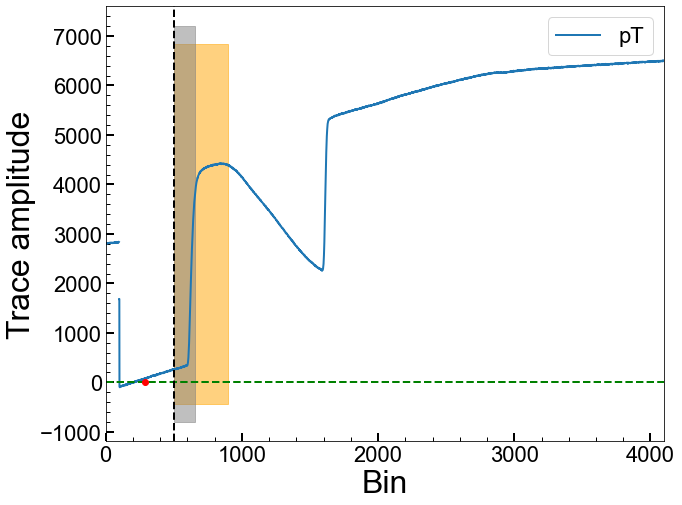

Series Number: 72209162200
Event Number: 1130006
Energy: 34.04177862434 keV


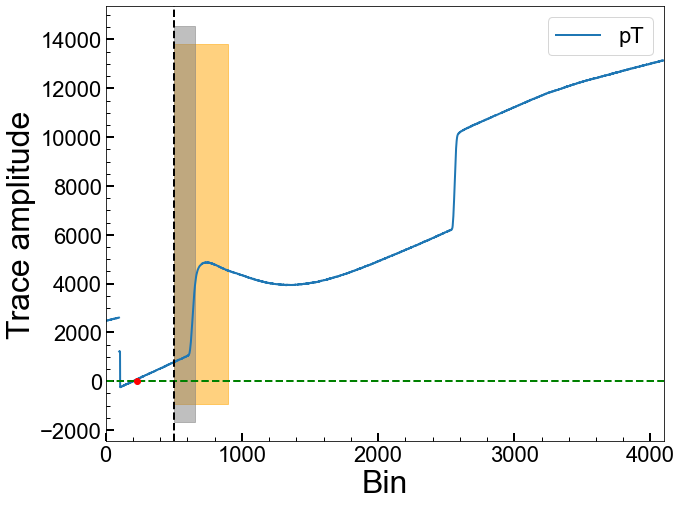

Series Number: 72209162200
Event Number: 1260636
Energy: 48.42700489778 keV


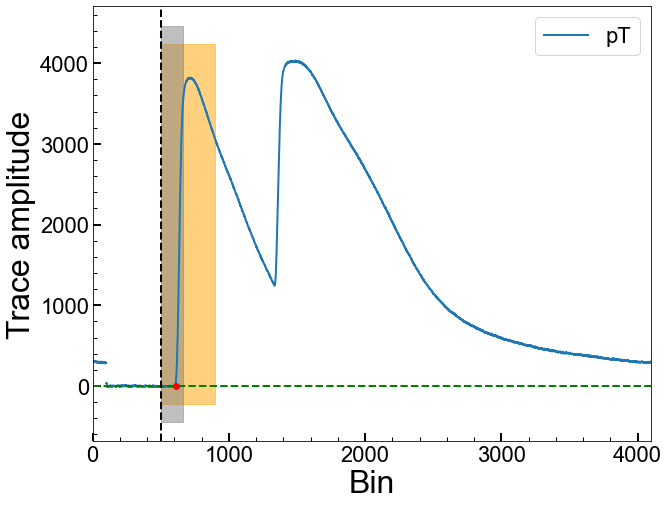

Series Number: 72209162200
Event Number: 1830115
Energy: 42.13844417863 keV


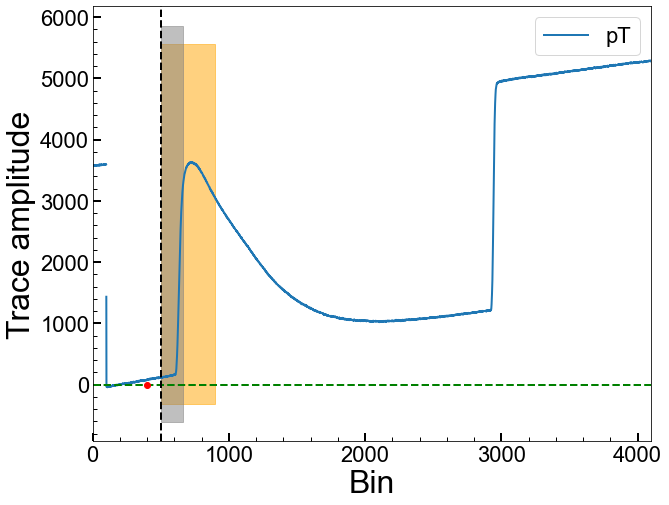

Series Number: 72209162200
Event Number: 2110321
Energy: 33.04935262098 keV


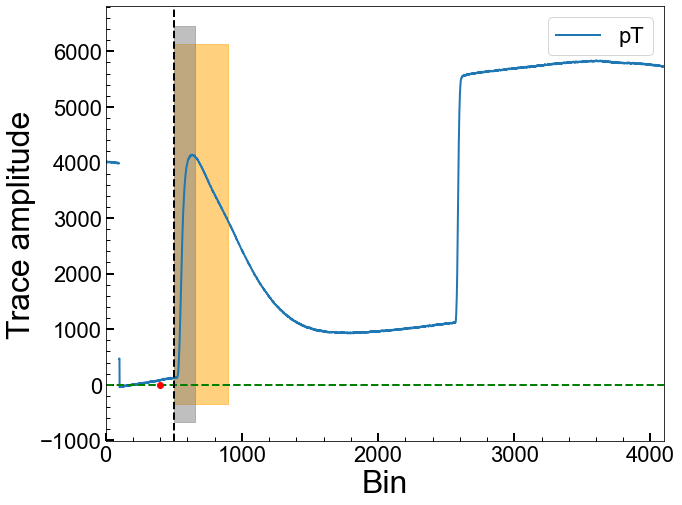

Series Number: 72209162200
Event Number: 2500665
Energy: 37.47752435397 keV


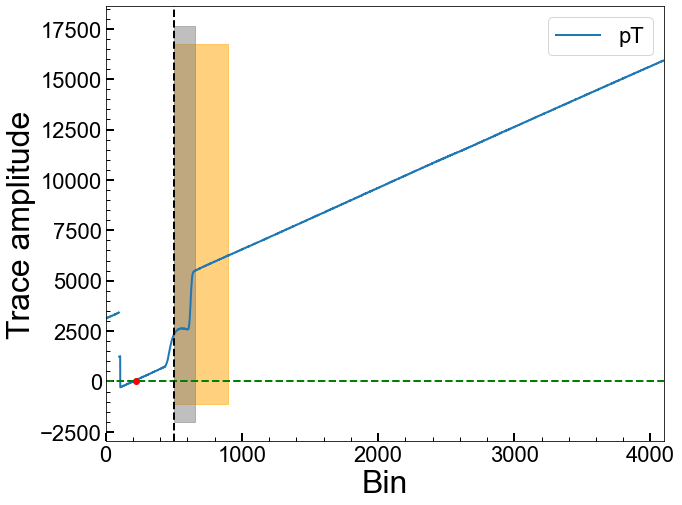

Series Number: 72209162200
Event Number: 2620773
Energy: 47.91406375709 keV


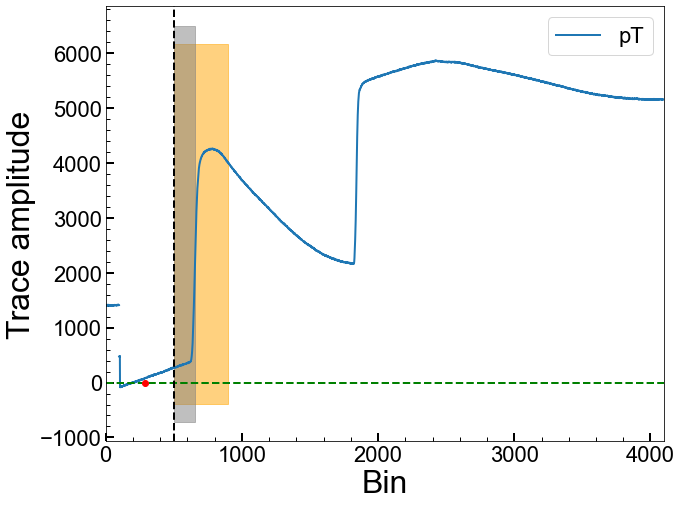

Series Number: 72209162200
Event Number: 3430119
Energy: 32.03605817262 keV


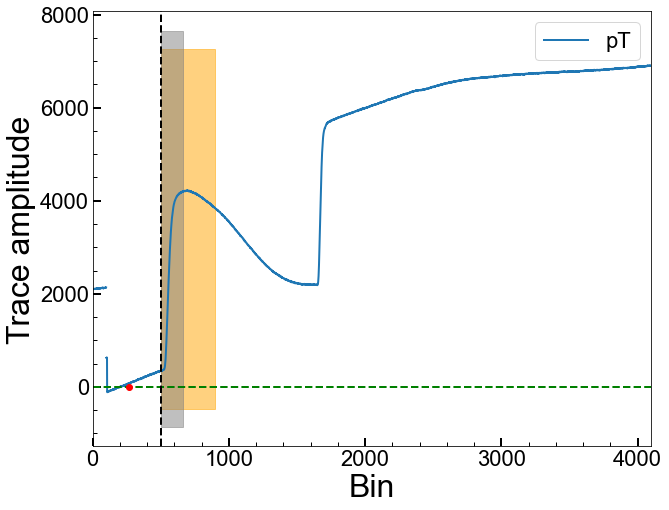

Series Number: 72209162200
Event Number: 3430598
Energy: 49.8815073324 keV


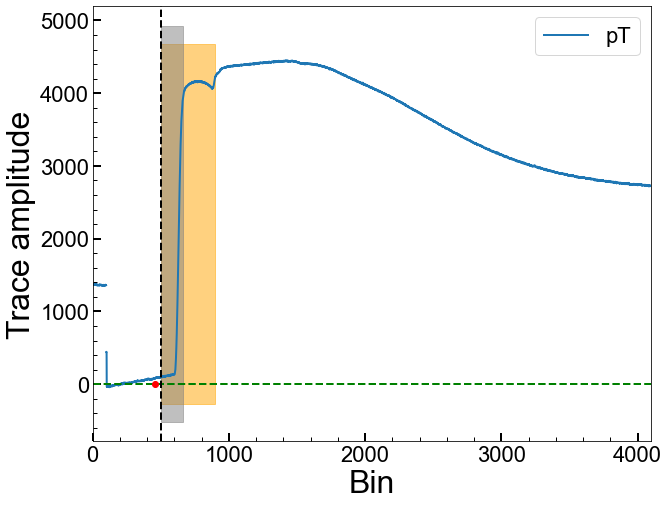

Series Number: 72209162200
Event Number: 4100643
Energy: 30.45051809168 keV


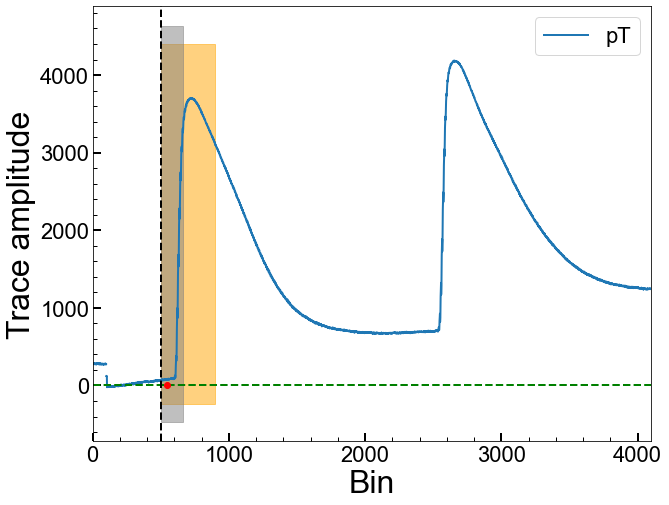

Series Number: 72209162200
Event Number: 5080548
Energy: 45.40178978913 keV


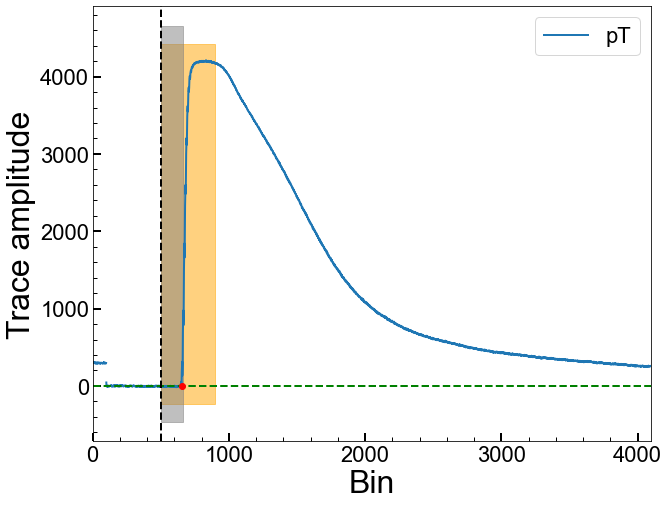

Series Number: 72209162200
Event Number: 5500243
Energy: 49.06733302235 keV


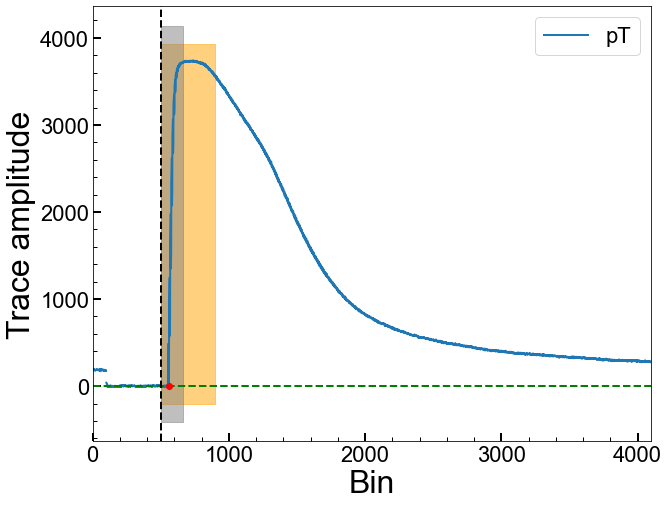

Series Number: 72209162200
Event Number: 5590678
Energy: 49.21250334678 keV


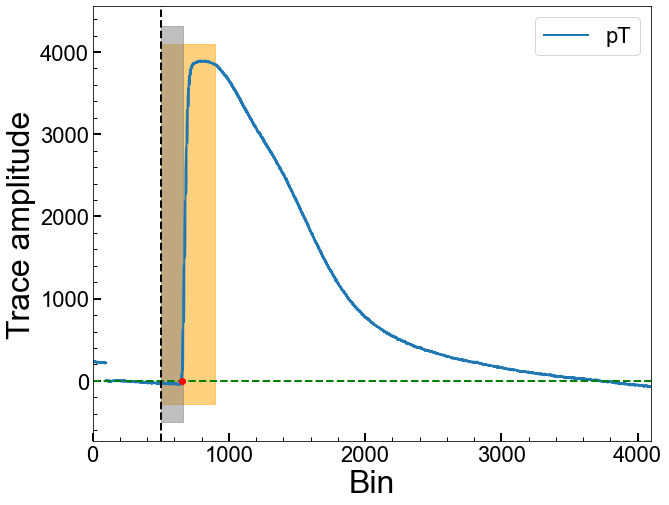

Series Number: 72209162200
Event Number: 5640434
Energy: 46.23784529851 keV


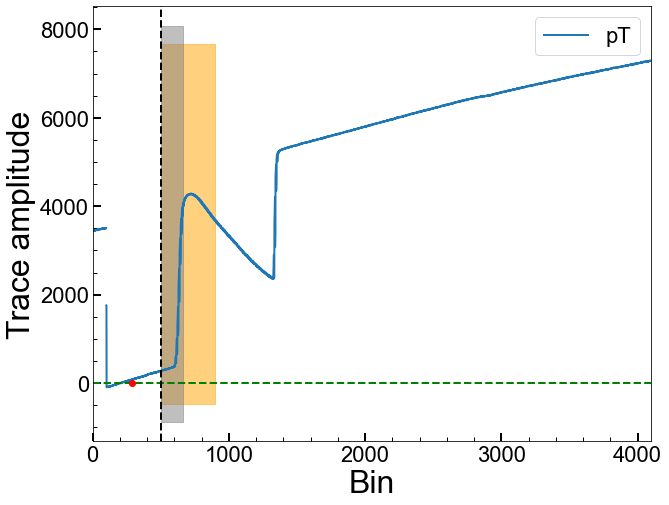

Series Number: 72209162200
Event Number: 5950460
Energy: 45.23014768465 keV


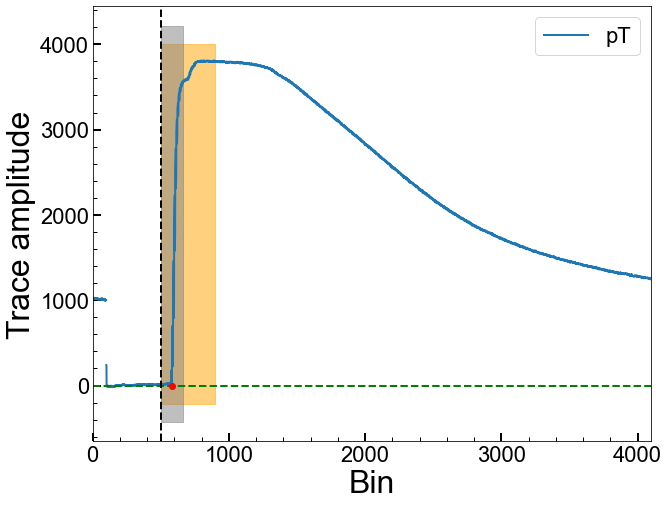

Series Number: 72209162200
Event Number: 6010388
Energy: 37.29845004939 keV


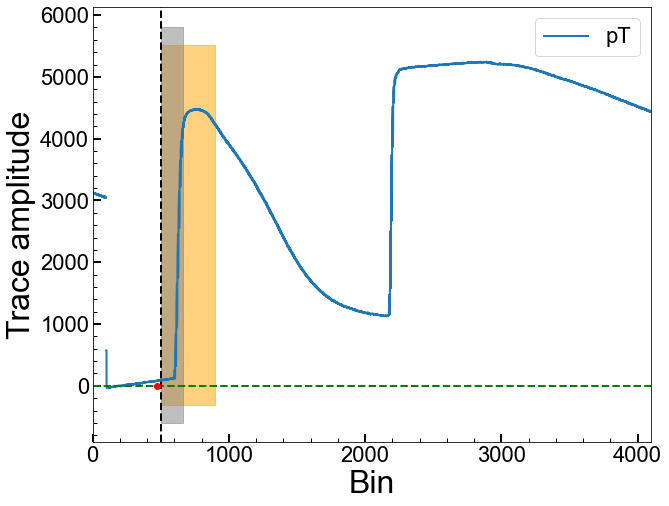

Series Number: 72209162200
Event Number: 6050033
Energy: 35.27750527578 keV


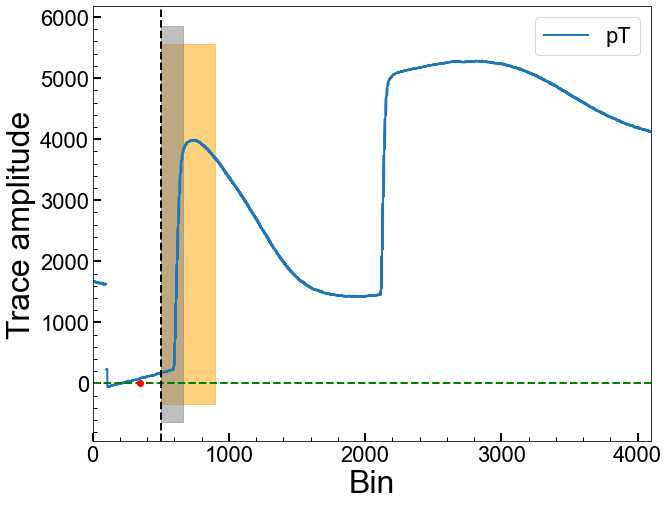

Series Number: 72209162200
Event Number: 6370722
Energy: 49.74105325663 keV


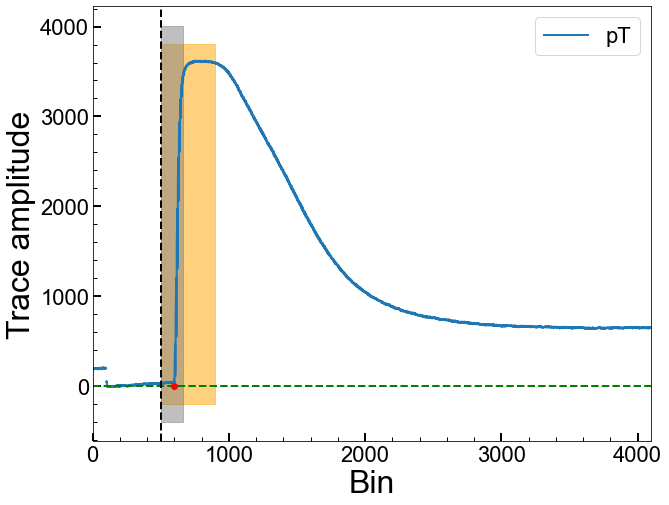

Series Number: 72209162200
Event Number: 6610717
Energy: 40.23007378752 keV


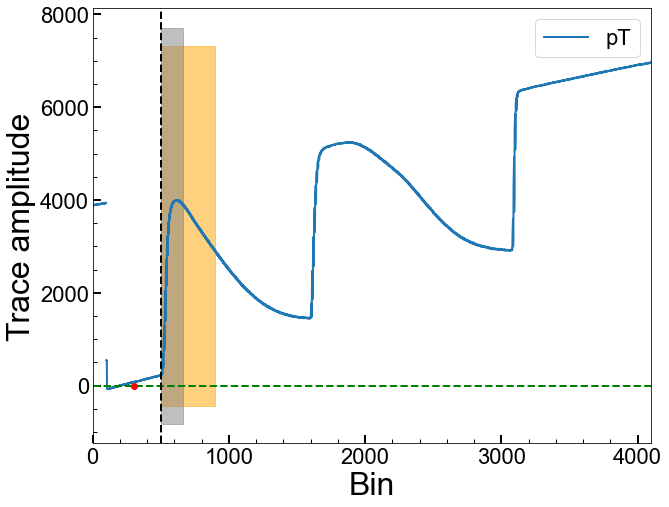

Series Number: 72209162200
Event Number: 7300339
Energy: 47.8145509351 keV


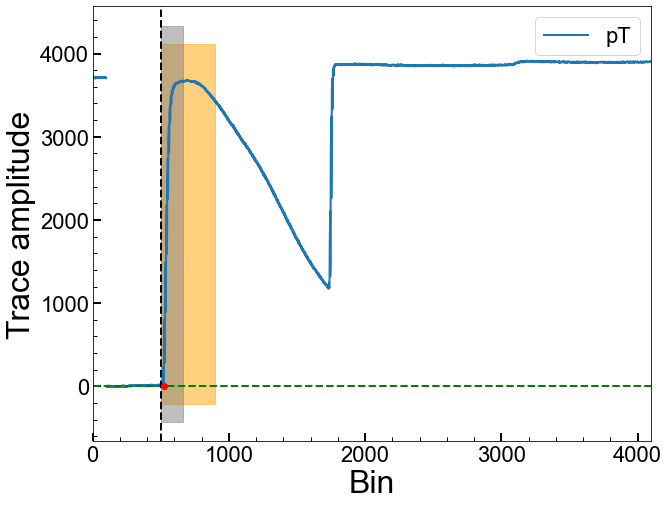

Series Number: 72209162200
Event Number: 7370515
Energy: 32.83239834487 keV


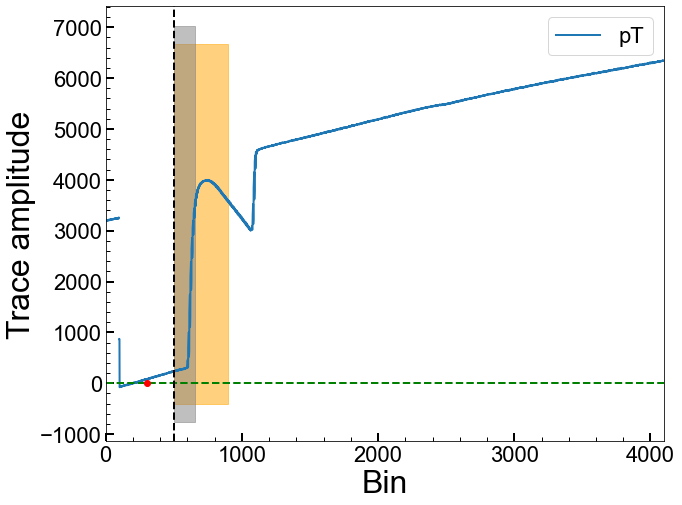

Series Number: 72209171225
Event Number: 300068
Energy: 32.89290741209 keV


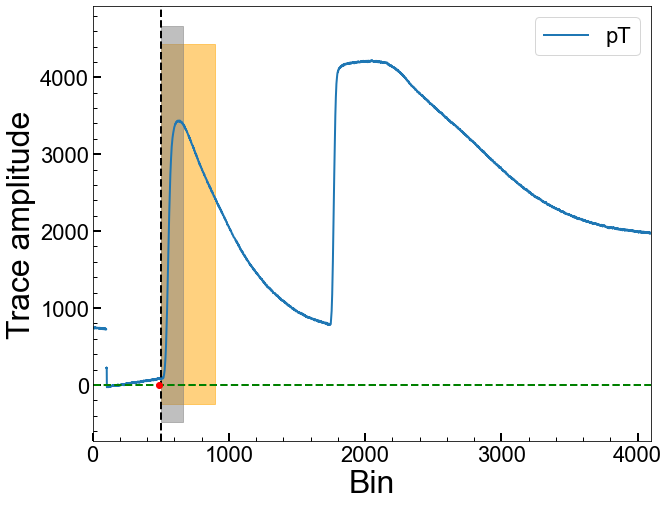

Series Number: 72209171225
Event Number: 560760
Energy: 34.95661758919 keV


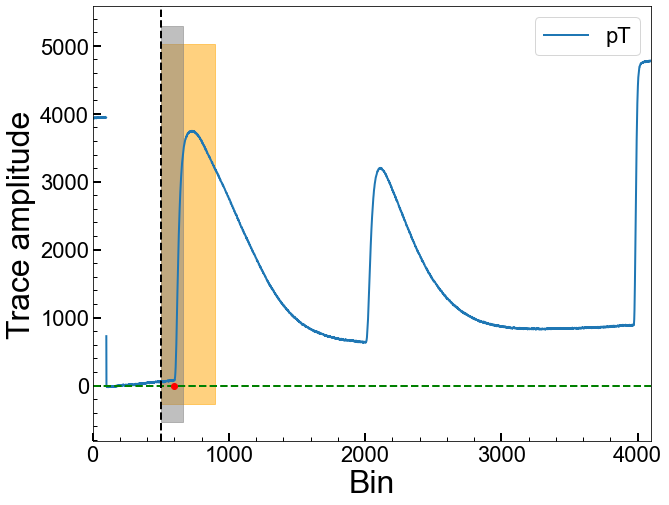

Series Number: 72209171225
Event Number: 590460
Energy: 34.58209807431 keV


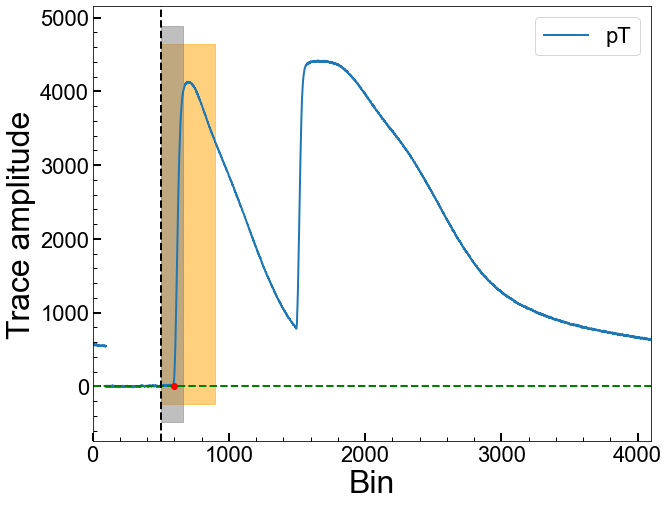

Series Number: 72209171225
Event Number: 1400479
Energy: 35.41937727087 keV


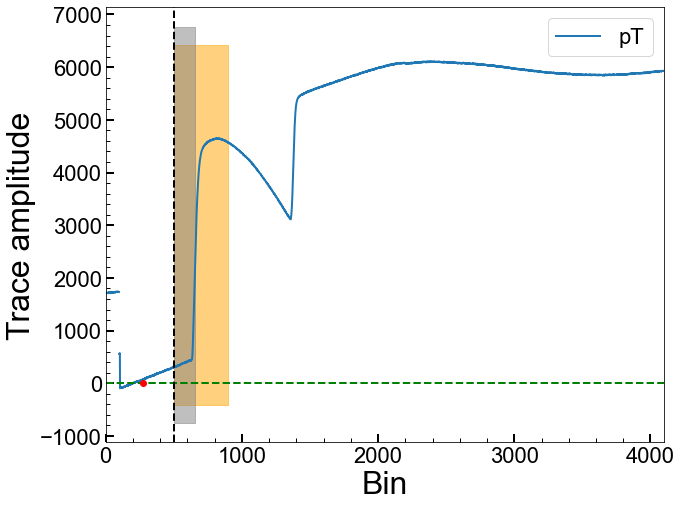

Series Number: 72209171225
Event Number: 2220296
Energy: 40.18558837798 keV


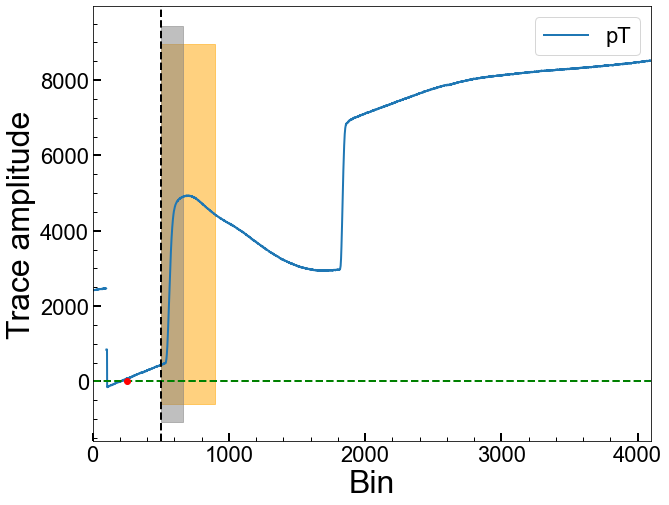

Series Number: 72209171225
Event Number: 2940228
Energy: 48.55329150194 keV


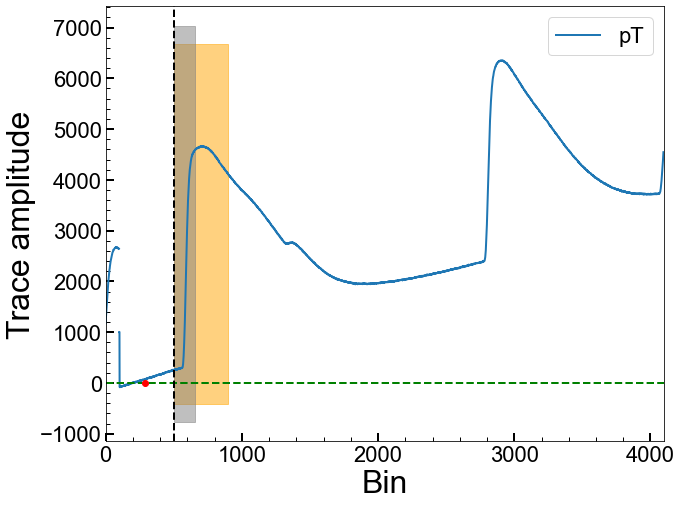

Series Number: 72209171225
Event Number: 3040695
Energy: 32.80725080574 keV


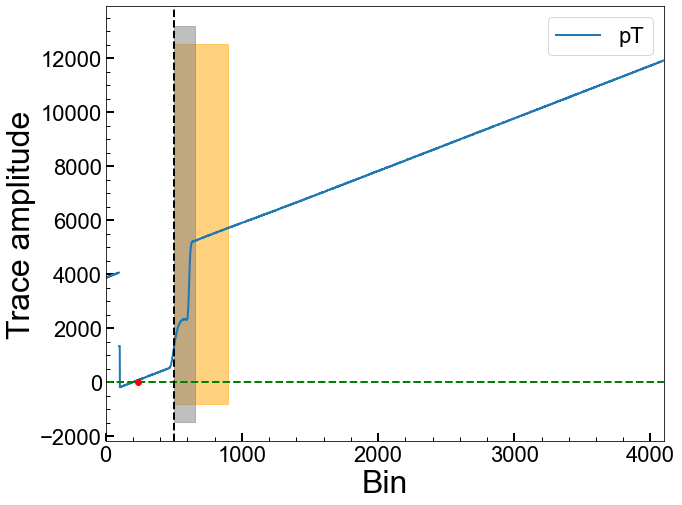

Series Number: 72209171225
Event Number: 3240393
Energy: 38.16445118885 keV


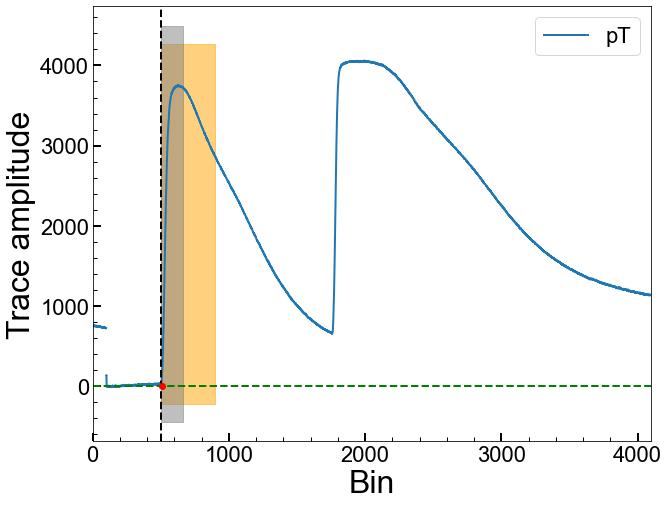

Series Number: 72209171225
Event Number: 3290733
Energy: 46.56340265802 keV


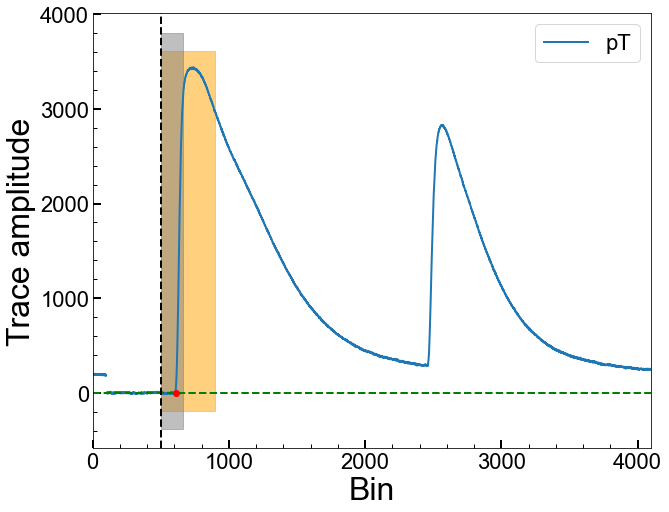

Series Number: 72209171225
Event Number: 3780179
Energy: 38.65723324875 keV


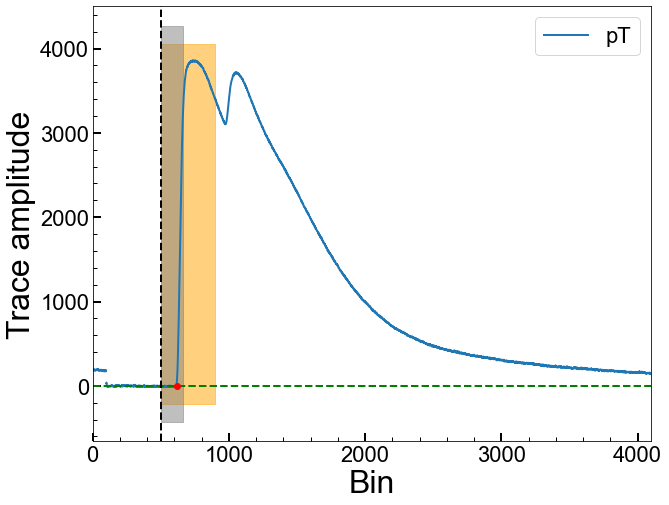

Series Number: 72209171225
Event Number: 3780935
Energy: 38.99365027936 keV


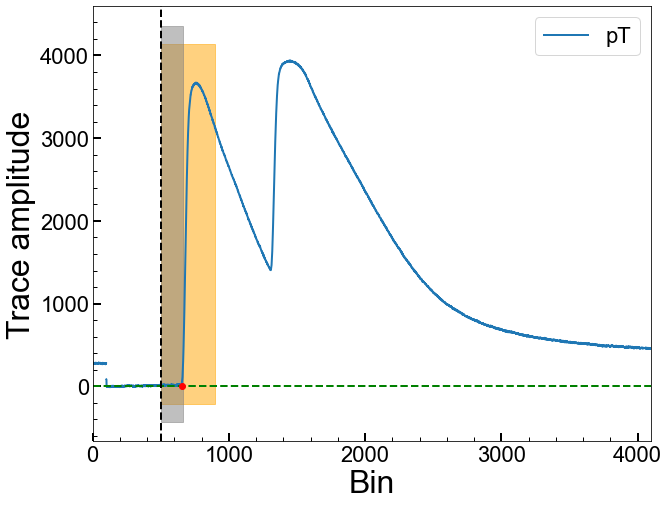

Series Number: 72209171225
Event Number: 3920450
Energy: 39.30297202985 keV


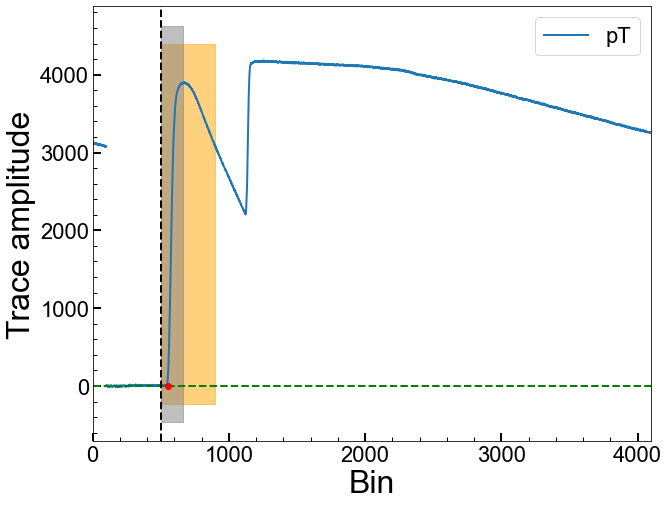

Series Number: 72209171225
Event Number: 3960112
Energy: 37.90140509621 keV


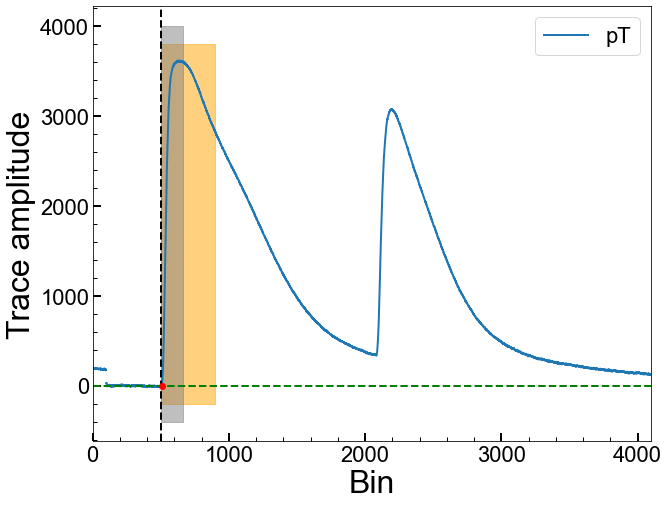

Series Number: 72209171225
Event Number: 4300405
Energy: 39.13542782909 keV


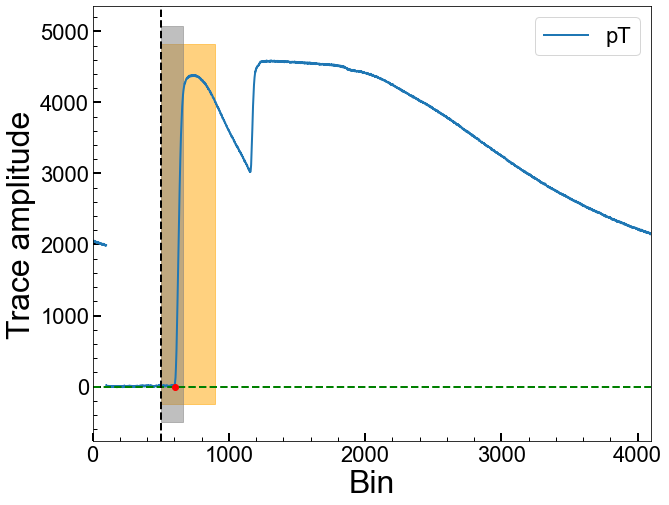

Series Number: 72209171225
Event Number: 4310034
Energy: 48.5504466119 keV


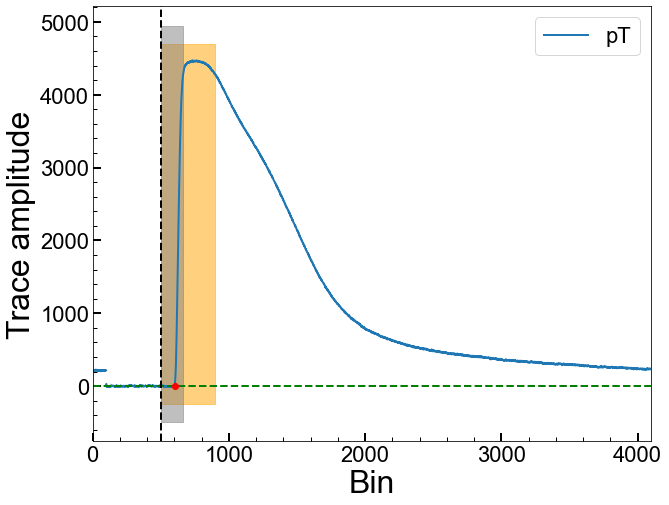

Series Number: 72209171225
Event Number: 5180397
Energy: 37.9189477984 keV


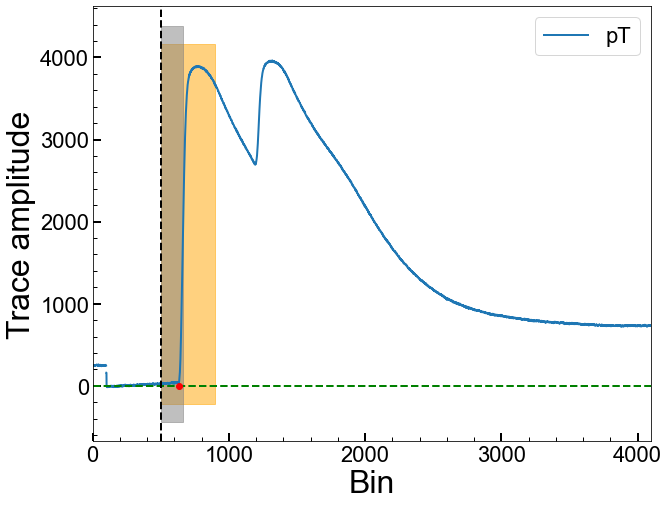

Series Number: 72209172155
Event Number: 290528
Energy: 31.06828588846 keV


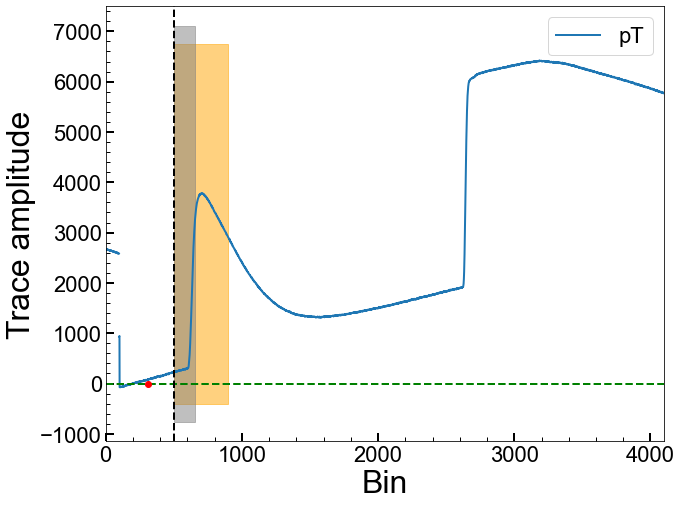

Series Number: 72209172155
Event Number: 490349
Energy: 35.31733253288 keV


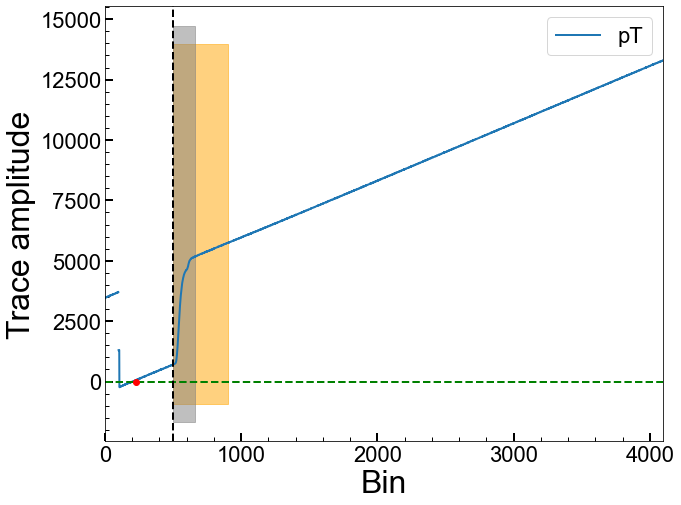

Series Number: 72209172155
Event Number: 590312
Energy: 37.82920093215 keV


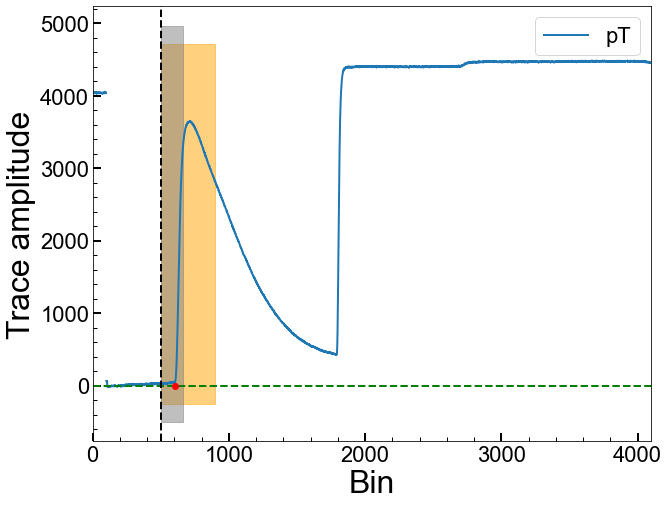

Series Number: 72209172155
Event Number: 1080099
Energy: 47.54789366116 keV


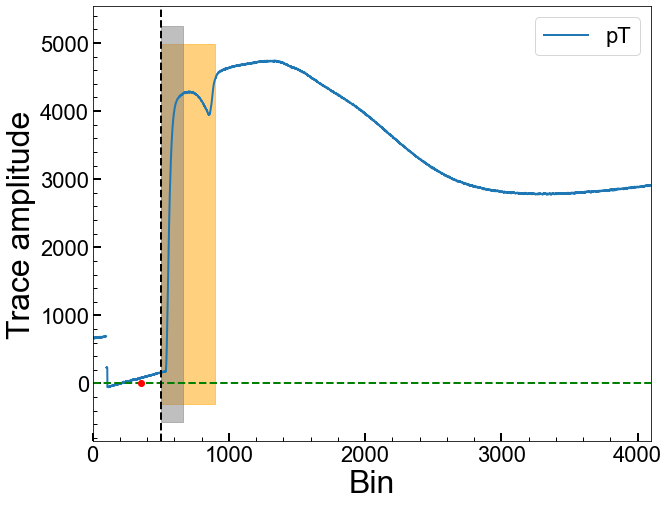

Series Number: 72209172155
Event Number: 1290044
Energy: 37.86060064076 keV


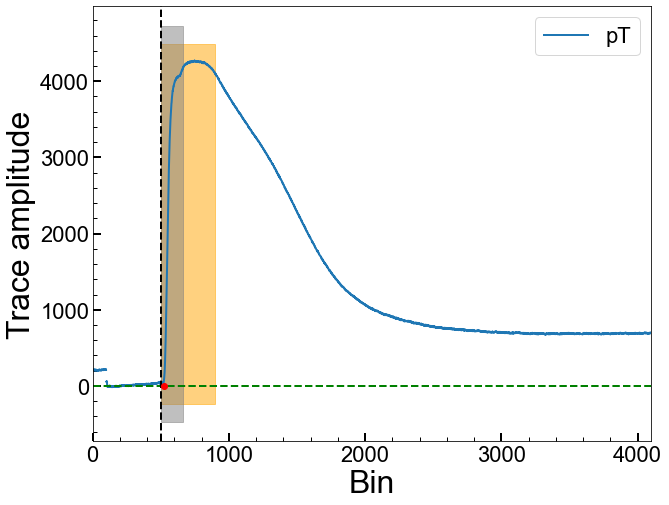

In [7]:
loops = 0
time_reg = []
energies = []
bad=[]
goodevs=[]
plot=True

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                if best_cross<500:
                    bad.append(loops)
                elif (energy<15):
                    goodevs.append(ev)
                    
            if (plot==True) and (getBadBL(exampleObj,ser,ev)) and (energy>30):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1